In [3]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import binom
from scipy.optimize import minimize, minimize_scalar
import matplotlib.pyplot as plt
import cloudpickle as cp
import os
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.collections import LineCollection
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys
from collections import defaultdict

In [4]:
algs = ["stationary", "nonstationary", 
]
envs = ["discretebandit_0", "discretebandit_1", 
        "discretebandit_2", "discretebandit_3",
]
genvs = ["dglucose_0", "dglucose_1",
         "dglucose_2", "dglucose_3"]
anames = ['Baseline', "SPIN"]
enames = ["Speed-0", "Speed-1", "Speed-2", "Speed-3"]

In [5]:
# need matplotlib version 3.1 not 3.3
matplotlib.__version__

'3.1.2'

In [6]:
pathlc1 = os.path.join("./data/", "nonstationary_learncurve.csv")
pathlc2 = os.path.join("./data/", "stationary_learncurve.csv")
dflc1 = pd.read_csv(pathlc1, header=0)
dflc2 = pd.read_csv(pathlc2, header=0)

In [7]:
base_dir = "./data/allenvs"

In [9]:
swps = defaultdict(dict)
swpsg = defaultdict(dict)

for alg in algs:
    for env in envs:
        path = os.path.join(base_dir, env, "allres_"+alg+".csv")

        if os.path.exists(path):
            df = pd.read_csv(path, header=0,skiprows=[int(i*11) for i in range(1,1000)])
            swps[alg][env] = df
        else:
            print(path, "does not exist")
    for env in genvs:
        path3 = os.path.join(base_dir, env, "allres_"+alg+".csv")
        df = pd.read_csv(path3, header=None, names=['tau', 'lambda', 'optratio', 'fborder', 'old_ent', 'obsperf', 'canperf',
       'algperf', 'regret', 'foundpct', 'violation'], comment="t")#,skiprows=[int(i*2)+1 for i in range(0,999)])
        swpsg[alg][env] = df

In [10]:
def ECDF(D, xs):
    #Assume D is sorted   
    return np.searchsorted(D, xs, side='right') / D.shape[0]
    #return np.arange(D.shape[0])/ float(D.shape[0])
    

def DKW(ecdf, n, delta):
    eps = np.sqrt(np.log(2./delta)/(2*n))
    lower = ecdf-eps
    upper = ecdf+eps
    return np.clip(lower, a_min=0., a_max=None), np.clip(upper, a_min=None, a_max=1.)
    
def anderson_bound(D, delta, a, b):
    # assume D sorted
    # alpha is cvar threshold
    # delta is CI
    # a is the lower bound on the Data
    # b is the upper bound on the Data
    N = D.shape[0]
    eps = np.sqrt(np.log(2./delta)/(2*N))
    
    Z = np.concatenate((D, [b]))
    tmp = np.clip((np.arange(1, N+1) / N) - eps, a_min=0, a_max=None)
    upd = np.sum(np.diff(Z) * tmp)
    upper = b - upd
    
    Z = np.concatenate(([a], D))
    tmp = np.clip((np.arange(0, N) / N) + eps, a_min=None, a_max=1)
    lwd = np.sum(np.diff(Z) * tmp)
    lower = D[-1] - lwd
    
    return lower, upper

def cdf(D, xs, delta):
    # Assume D is sorted
    ecdf = ECDF(D, xs)
    lower, upper = DKW(ecdf, D.shape[0], delta)
    return ecdf, lower, upper

def comp_mean(D, delta, a, b):
    mn = D.mean()
    ml, mu = anderson_bound(D, delta, a, b)
    stderr = np.std(D) / np.sqrt(D.size)
    return mn, ml, mu, mn-stderr, mn+stderr
    
def comp_and_bound(D, xs, quants, alpha, delta, a, b, n, m):
    N = D.shape[0]
    
    mn, ml, mh, ml2, mh2 = comp_mean(D, delta, a, b)
    
    ec, el, eh = cdf(D, xs, delta)
    
    
    mns = (mn, ml, mh, ml2, mh2)
    ecs = (ec, el, eh, xs)
    
    return mns, ecs


In [11]:
def compstats(D, a, b, delta):
    # D is returns, [a,b] are min max possible values, delta is conf interval
    D.sort()
    Dmin = D.min()
    Dmax = D.max()
#     print(Dmin, Dmax)
    Drange = Dmax-Dmin
    if abs(Drange) < 1e-2:
        Drange = 1.0
#     xs = np.arange(a, b+0.0000001, (b-a)/10000.)
    xs = np.copy(D)
    quants = np.arange(0+1e-3, 1., 0.001)
    sizeBoot= 1000
    numBoot = 1000
    alpha = 0.5  # cvar alpha
    mns, ecs = comp_and_bound(D, xs, quants, alpha, delta, a, b, n=sizeBoot, m=numBoot)
    return mns, ecs

def compall(dfs, enames, algnames, delta, perf="life"):
    stats = defaultdict(dict)
    for ename in enames:
        a,b = 0,0
        rets = []
        for aname in algnames:
            ret = dfs[aname][ename].loc[:, perf].values.tolist()
            if np.any(np.isnan(ret)):
                print(aname, ename)
            rets.extend(ret)
        a = np.min(rets)
        b = np.max(rets)
        if perf in ["violation", "foundpct"]:
            a,b = 0.0,1.0
            
        for aname in algnames:
            mns, ecs = compstats(dfs[aname][ename].loc[:, perf].values, a, b, delta)
            d = {}
            d['mean'] = mns[0]
            d['mean_low'] = mns[1]    # Andersons Bound
            d['mean_high'] = mns[2]   # Andersons Bound
            d['mean_lows'] = mns[3]    # t-dist CI
            d['mean_highs'] = mns[4]   # t-dist CI
            d['cdf'] = ecs[0]
            d['cdf_low'] = ecs[1]  # DKW
            d['cdf_high'] = ecs[2] # DKW
            d['cdf_x'] = ecs[3] # x inputs 
            d['a'] = a
            d['b'] = b
            
            stats[ename][aname] = d
    return stats

In [12]:
delta_all = 0.05 / 1# use this as denom to bound all (len(envs) * len(algs))
print("num envs: ", len(envs), "num algs: ", len(algs), 1.-delta_all)

sfound2 = compall(swps, envs, algs, delta=delta_all, perf="foundpct")
sfail2 = compall(swps, envs, algs, delta=delta_all, perf="violation")
scan2 = compall(swps, envs, algs, delta=delta_all, perf="canperf")
salg2 = compall(swps, envs, algs, delta=delta_all, perf="algperf")
sobs2 = compall(swps, envs, algs, delta=delta_all, perf="obsperf")
regret2 = compall(swps, envs, algs, delta=delta_all, perf="regret")

sfound3 = compall(swpsg, genvs, algs, delta=delta_all, perf="foundpct")
sfail3 = compall(swpsg, genvs, algs, delta=delta_all, perf="violation")
scan3 = compall(swpsg, genvs, algs, delta=delta_all, perf="canperf")
salg3 = compall(swpsg, genvs, algs, delta=delta_all, perf="algperf")
sobs3 = compall(swpsg, genvs, algs, delta=delta_all, perf="obsperf")
regret3 = compall(swpsg, genvs, algs, delta=delta_all, perf="regret")

num envs:  4 num algs:  2 0.95


In [13]:
dbenames = [enames[i] for i in [0,1,2,3]]
dbenvs = [envs[i] for i in [0,1,2,3]]
gbenvs = [genvs[i] for i in [0,1,2,3]]

In [14]:
# from https://stackoverflow.com/questions/31544489/two-line-styles-in-legend

class HandlerDashedLines(HandlerLineCollection):
    """
    Custom Handler for LineCollection instances.
    """
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = ((height) / (numlines + 1)) * np.ones(xdata.shape, float)
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] != None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

In [20]:
def barplot_res(axs, means, lows, highs, bs, speeds, colors, ylabel, is_pct=False, label_x=True, label_y=True, label_yticks=True, plot_safeline=False):
    width = 0.3
    ind = np.arange(len(speeds))
    if plot_safeline:
        maxpos = np.max(ind) + len(means)*width
        axs.hlines(5.0, xmin=-width, xmax=maxpos, linestyle="dashed")
        axs.set_xlim(-width, maxpos)
    for i in range(len(means)):
        mns, lws, his, b = np.array(means[i]), np.array(lows[i]), np.array(highs[i]), np.array(bs[i])
        if is_pct:
            axs.bar(ind + i*width, 100*mns, yerr=100*np.array([mns-lws, his-mns]), width=width, color=colors[i])
        else:
            axs.bar(ind + i*width, mns/b, yerr=np.array([mns-lws, his-mns])/b, width=width, color=colors[i])
    
    
    axs.set_xticks(ind + width)
    axs.set_xticklabels(speeds)
    if not label_yticks:
        axs.set_yticklabels([])
    if label_x:
        axs.set_xlabel("Speed")
    if label_y:
        axs.set_ylabel(ylabel)

In [21]:
def plot_curve_bar(dfs, stats, speeds, gstats, gspeeds):
    fig3 = plt.figure()
    gs = fig3.add_gridspec(2, 4, wspace=0.7)

    # learning curves
    f3_ax1 = fig3.add_subplot(gs[0, :2])
    f3_ax2 = fig3.add_subplot(gs[1, :2])
    f3_ax1.set_title("RecoSys (Speed 2)")
    t1, mnunsafe1, stdunsafe1, mnfound1, stdfound1, mnJpi1, stdJpi1, mnJalg1, stdJalg1, baseline = [dfs[0][col] for col in ['t', 'mnsafe', 'stdsafe', 'mnfound', 'stdfound', 'mnJpi', 'stdJpi', 'mnJalg', 'stdJalg', 'baseline']] 
    t2, mnunsafe2, stdunsafe2, mnfound2, stdfound2, mnJpi2, stdJpi2, mnJalg2, stdJalg2, _ = [dfs[1][col] for col in ['t', 'mnsafe', 'stdsafe', 'mnfound', 'stdfound', 'mnJpi', 'stdJpi', 'mnJalg', 'stdJalg', 'baseline']] 
    
    f3_ax1.plot(t1, mnJalg1, color="crimson")
    f3_ax1.fill_between(t1, mnJalg1+stdJalg1, mnJalg1-stdJalg1, color="crimson", alpha=0.4)
    f3_ax1.plot(t1, mnJpi1, color="crimson", linestyle="dashed")
    f3_ax1.plot(t2, mnJalg2, color="dodgerblue")
    f3_ax1.fill_between(t2, mnJalg2+stdJalg2, mnJalg2-stdJalg2, color="dodgerblue", alpha=0.4)
    f3_ax1.plot(t2[::5], mnJpi2[::5], color="dodgerblue", linestyle="dashed")
    f3_ax1.set_ylabel("Performance")
    f3_ax1.plot(t1, baseline, color="black", linestyle="dashed")
    
    f3_ax2.plot(t1, 100*mnunsafe1, color="crimson", linestyle="solid")
    f3_ax2.plot(t2, 100*mnunsafe2, color="dodgerblue", linestyle="solid")

    f3_ax2.set_xlabel("Episodes")
    f3_ax2.set_ylabel(r"$\%$ Unsafe Policies Used")

    line = [[(0, 0)]]
    lc1 = Line2D(np.array([0]), np.array([0]), linestyle="dashed", color="black", label=r"$\pi_\mathtt{safe}$")
    lc2 = Line2D(np.array([0]), np.array([0]), linestyle="solid", color="crimson", label=r"Baseline"),
    lc3 = Line2D(np.array([0]), np.array([0]), linestyle="solid", color="dodgerblue", label=r"SPIN"),
    lc4 = LineCollection(2 * line, linestyles = ['dashed', 'dashed'], colors = ['crimson', 'dodgerblue'])
    lc5 = LineCollection(2 * line, linestyles = ['dotted', 'dotted'], colors = ['crimson', 'dodgerblue'])

    f3_ax2.legend([lc1, lc2, lc3, lc4], [r"$\pi^\mathrm{safe}$", "Baseline", "SPIN", r"$\pi_\mathrm{c}$"], 
               handler_map = {type(lc4) : HandlerDashedLines()}, 
                  handlelength = 2.0,
               loc='lower right', ncol=4, bbox_to_anchor=(1.9, -0.5), fancybox=False) 
    
    fig3.subplots_adjust(bottom=0.17, left=0.1, right=0.99, top=0.95)
        
    
    # BAR PLOTS
    colors = ["crimson", "dodgerblue", "darkorange"]
    
    ylabels = [r"$\%$ Unsafe Policies Used", r"Improvement over $\pi^\mathrm{safe}$"]
    
    f3_ax3 = fig3.add_subplot(gs[1, 2])
    means, lows, highs, bs = stats[0]
    barplot_res(f3_ax3, means, lows, highs, bs, speeds, colors, ylabels[0], is_pct=(r"$\%$" in ylabels[0]), label_x=True, label_y=True, plot_safeline=True)
    f3_ax4 = fig3.add_subplot(gs[0, 2])
    means, lows, highs, bs = stats[1]
    barplot_res(f3_ax4, means, lows, highs, bs, speeds, colors, ylabels[1], is_pct=(r"$\%$" in ylabels[1]), label_x=False, label_y=True)
    f3_ax4.set_title("RecoSys")
    
    
    f3_ax5 = fig3.add_subplot(gs[1, 3])
    means, lows, highs, bs = gstats[0]
    barplot_res(f3_ax5, means, lows, highs, bs, gspeeds, colors, ylabels[0], is_pct=(r"$\%$" in ylabels[0]), label_x=True, label_y=False, label_yticks=True, plot_safeline=True)
    f3_ax6 = fig3.add_subplot(gs[0, 3])
    means, lows, highs, bs = gstats[1]
    barplot_res(f3_ax6, means, lows, highs, bs, gspeeds, colors, ylabels[1], is_pct=(r"$\%$" in ylabels[1]), label_x=False, label_y=False, label_yticks=True)
    f3_ax6.set_title("Diabetes")
    fig3.savefig("lc_with_both_cr_1k.pdf", dpi=300, bbox_inches = 'tight',pad_inches = 0)



In [22]:
def get_stats_data(allstats, algs, envs, anames):   
    pstats = []
    for stats in allstats:
        mids, lows, highs, bss = [], [], [], []
        for alg in algs:
            ms, ls, hs, bs = [], [], [], []
            for i, env in enumerate(envs):
                ms.append(stats[env][alg]['mean'])
                ls.append(stats[env][alg]['mean_lows'])
                hs.append(stats[env][alg]['mean_highs'])
                bs.append(stats[env][alg]["b"])
            mids.append(np.array(ms))
            lows.append(np.array(ls))
            highs.append(np.array(hs))
            bss.append(np.array(bs))
#             print(alg, env, np.array(bs))
        pstats.append([mids, lows, highs, bss])
    return pstats

In [23]:
allstats = [sfail2, regret2]
allstatsg = [sfail3, regret3]

<IPython.core.display.Javascript object>


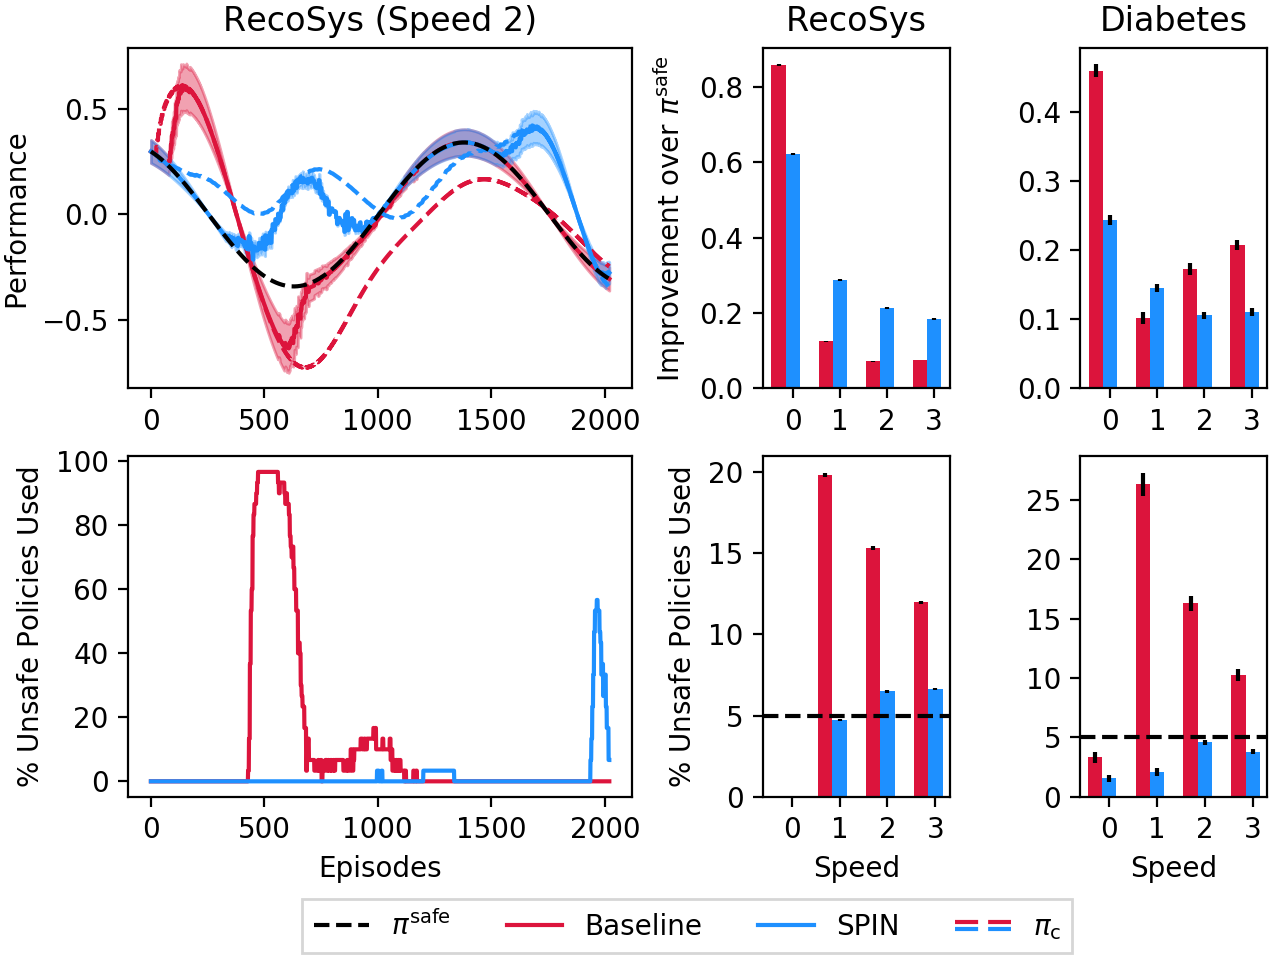

In [24]:
plot_curve_bar([dflc2, dflc1], 
               get_stats_data(allstats, algs, dbenvs, anames), 
               np.array([0,1,2,3]), 
               get_stats_data(allstatsg, algs, gbenvs, anames), 
               np.array([0,1,2,3]))